Name : Muchammad Romadona <br>
NIM : 211351085 <br>
Kelas : Malam B

#Import Dataset

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"loyaltyy","key":"0deea36a5e8c9388d7e52b8362b2ddda"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [3]:
!kaggle datasets download -d aryashah2k/credit-card-customer-data

credit-card-customer-data.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
!unzip credit-card-customer-data.zip -d dataset
!ls dataset

Archive:  credit-card-customer-data.zip
replace dataset/Credit Card Customer Data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: dataset/Credit Card Customer Data.csv  
'Credit Card Customer Data.csv'


Selesai mengunduh datasets yang dipilih, selanjutnya saya akan mengimport library yang dibutuhkan serta mengextract datasets yang tadi diunduh.

#Import Library

In [5]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
import seaborn as sns
import pickle

#Data Discovery

In [6]:
df = pd.read_csv('dataset/Credit Card Customer Data.csv')

In [7]:
df.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


Datasets telah berhasil dibaca menggunakan pandas, terdapat 7 columns pada datasetsnya namun yang akan gunakan nanti hanyalah 2 columns, yaitu column Avg_Credit_Limit dan Total_Credit_Cards. Sebelumnya saya akan melihat apakah datasets ini memiliki nilai null atau tidak.

In [8]:
df.isnull().sum()

Sl_No                  0
Customer Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

tidak ada yang null ya, selanjutnya kita akan melihat korelasi antar columns menggunakan heatmap.

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


Semua kolomnya berjenis integer ya! ini memudahkan kita dalam proses preprocessingnya.

In [10]:
df.describe()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
count,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000
mean,330.500000,55141.443939,34574.242424,4.706061,2.403030,2.606061,3.583333
std,190.669872,25627.772200,37625.487804,2.167835,1.631813,2.935724,2.865317
min,1.000000,11265.000000,3000.000000,1.000000,0.000000,0.000000,0.000000
25%,165.750000,33825.250000,10000.000000,3.000000,1.000000,1.000000,1.000000
50%,330.500000,53874.500000,18000.000000,5.000000,2.000000,2.000000,3.000000
75%,495.250000,77202.500000,48000.000000,6.000000,4.000000,4.000000,5.000000
max,660.000000,99843.000000,200000.000000,10.000000,5.000000,15.000000,10.000000


Disini terlihat di dalam datasetsnya terdapat 660 baris data. Cukup banyak.

#EDA

<Axes: >

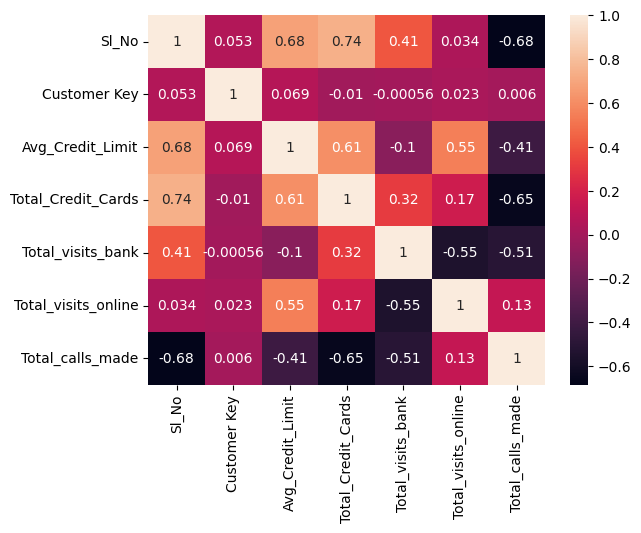

In [11]:
sns.heatmap(df.corr(), annot=True)

Diatas merupakan heatmap untuk menunjukkan korelasi antar kolomnya. Bisa dilihat ya Total_visits_bank memiliki korelasi yang cukup tinggi dengan Total_Credit_Cards yaitu 32% dan Total_visits_online memiliki korelasi tertinggi dengan Avg_Credit_Limit. Saya tidak akan melihat pada kolom Sl_No karena itu hanyalah serial numbernya.

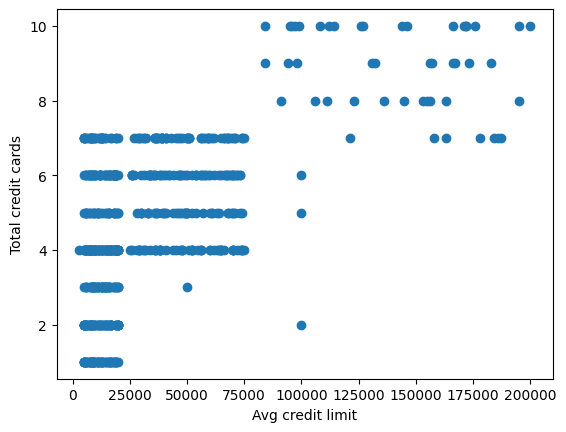

In [12]:
plt.scatter(df["Avg_Credit_Limit"], df["Total_Credit_Cards"])
plt.xlabel("Avg credit limit")
plt.ylabel("Total credit cards")
plt.show()

Diatas merupakan data yang nantinya akan kita clusterkan karena untuk membuat sebuah klasifikasi member/credit card kedua hal itulah yang paling utama. Jumlah credit card yang dimiliki dan credit limit yang dimiliki pengguna.

Kita akan melihat histogram dari masing masing column yang ngga kalah penting dari 2 column diatas

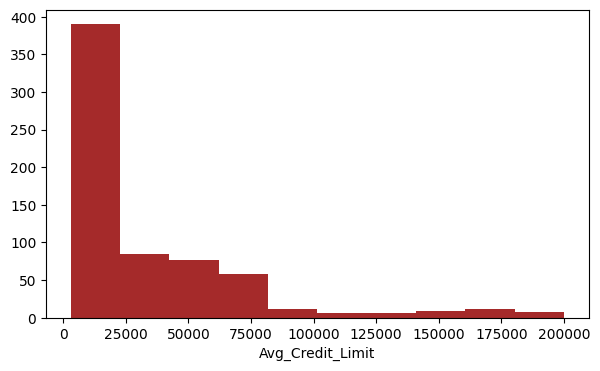

In [13]:
fig, ax = plt.subplots(figsize=(7, 4))
ax.hist(df["Avg_Credit_Limit"], color="brown")
ax.set_xlabel("Avg_Credit_Limit")
plt.show()

Rata-rata credit limitnya berada dibawah angka 25000.

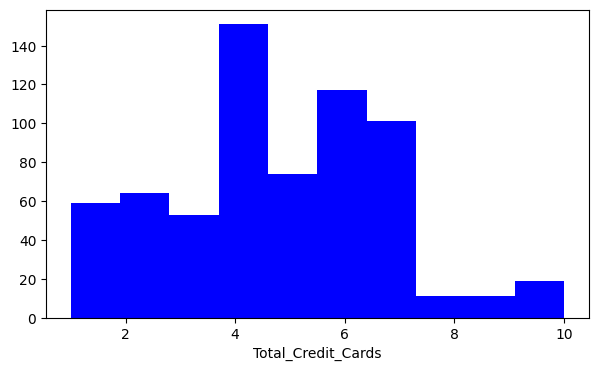

In [14]:
fig, ax = plt.subplots(figsize=(7, 4))
ax.hist(df["Total_Credit_Cards"], color="blue")
ax.set_xlabel("Total_Credit_Cards")
plt.show()

Diatas kita bisa lihat bahwa orang-orang kebanyakan memiliki 4 jumlah credit card. Diikuti dengan 6 credit card.

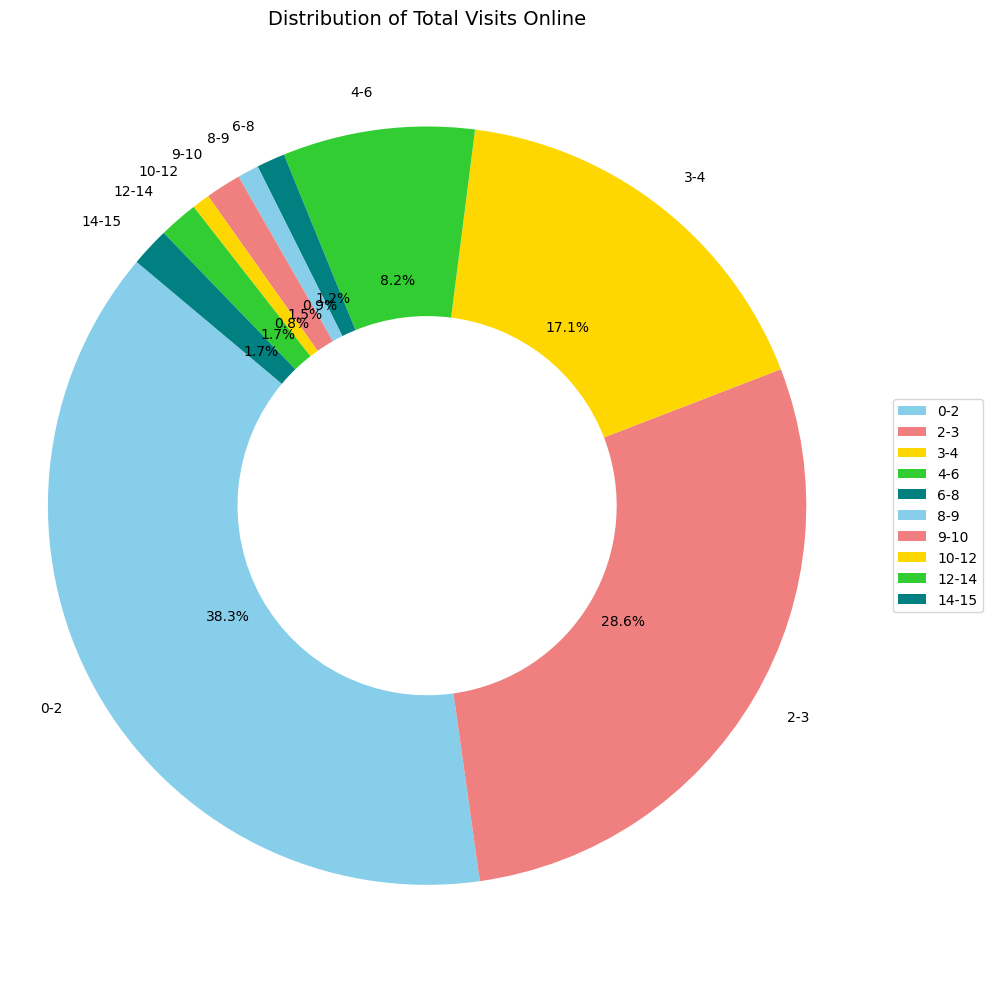

In [31]:
counts, bins, patches = ax.hist(df["Total_visits_online"], bins=10)

labels = [f"{b:.0f}-{b + (bins[1] - bins[0]):.0f}" for b in bins[:-1]]

plt.figure(figsize=(10, 10))
plt.pie(counts, labels=labels, autopct="%1.1f%%", startangle=140, colors=["skyblue", "lightcoral", "gold", "limegreen", "teal"],
       wedgeprops=dict(width=0.6), radius=1.2)

plt.axis("equal")
plt.title("Distribution of Total Visits Online", fontsize=14)
plt.legend(labels, loc="center left", bbox_to_anchor=(1.05, 0.5))
plt.tight_layout()
plt.show()

Bisa dilihat di atas bahwa pelanggan mayoritas hanya melakukan kunjungan secara online beberapa kali, antara 0-2 kali adalah 38.3%.

Setelah itu kita akan menentukan fitur yang akan kita gunakan, yaitu Avg_Credit_Limit dan Total_Credit_Cards.

#Preprocessing

In [32]:
x = df.iloc[:,[2,3]]
x

,Avg_Credit_Limit,Total_Credit_Cards
0,100000,2
1,50000,3
2,50000,7
3,30000,5
4,100000,6
...,...,...
655,99000,10
656,84000,10
657,145000,8
658,172000,10


Selanjutnya kita akan mencari nilai K yang paling optimal untuk digunakan dengan cara mencari elbow point dari hasil kmeans. Berikut kodenya,

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

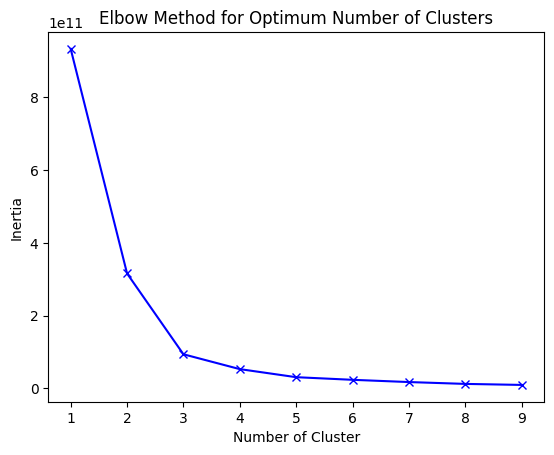

In [33]:

kmeans = KMeans()
inertia = []
K = range(1, 10)

for k in K:
    kmeans = KMeans(n_clusters=k).fit(x)
    inertia.append(kmeans.inertia_)

plt.plot(K, inertia, "bx-")
plt.xlabel("Number of Cluster")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimum Number of Clusters")
plt.show()

Bisa dilihat diatas bahwa 3 merupakan nilai K nya karena perubahan dari angka 3 ke angka 4 sangat kecil sedangkan dari angka 2 ke angka 3 sangatlah significant sehingga menjadikan angka 3 ini menjadi nilai K yang paling optimal.

#Modeling

In [34]:
kmeans = KMeans(n_clusters=3).fit(x)
print(kmeans.cluster_centers_)
kmeans.labels_

[[1.38491879e+04 3.88863109e+00]
 [1.54205128e+05 8.74358974e+00]
 [5.70315789e+04 5.73157895e+00]]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([2, 2, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [35]:
clusters_kmeans = kmeans.labels_
df["cluster"] = clusters_kmeans
df.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,cluster
0,1,87073,100000,2,1,1,0,2
1,2,38414,50000,3,0,10,9,2
2,3,17341,50000,7,1,3,4,2
3,4,40496,30000,5,1,1,4,0
4,5,47437,100000,6,0,12,3,2


#Visualisasi Hasil Algorithm

Membuat plot box untuk melihat Avg credit limit vs cluster dan total credit cards vs clusternya

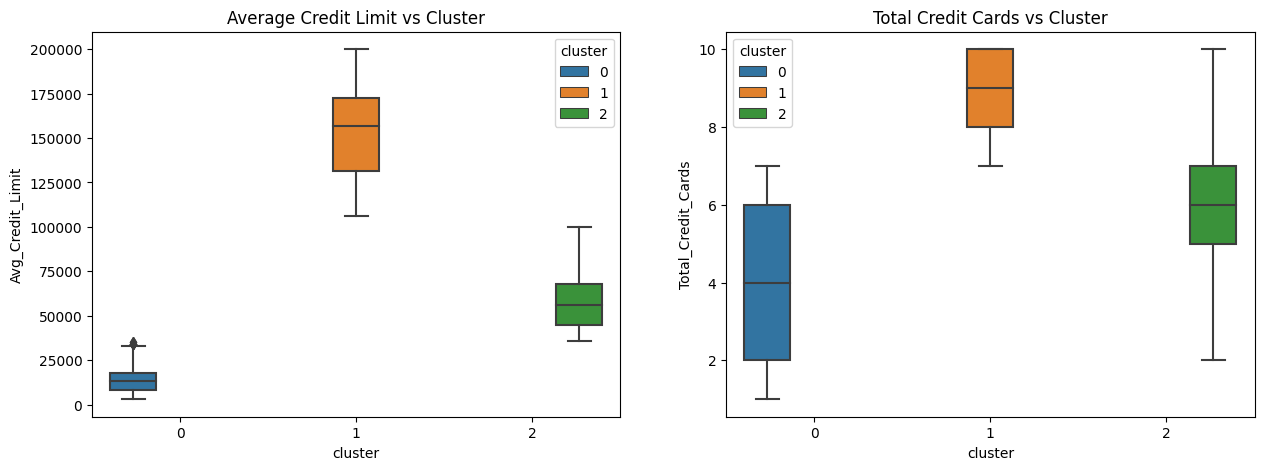

In [36]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))

plt.subplot(1,2,1)
sns.boxplot(data = df, x = "cluster", y = "Avg_Credit_Limit", hue = "cluster");
plt.title("Average Credit Limit vs Cluster")

plt.subplot(1,2,2)
sns.boxplot(data = df, x = "cluster", y = "Total_Credit_Cards", hue = "cluster");
plt.title("Total Credit Cards vs Cluster")

plt.show()

Dan langkah terakhir adalah membuat plot yang sudah meng-cluster data-data dan menunjukkan titik tengah dari masing-masing cluster yang ada.

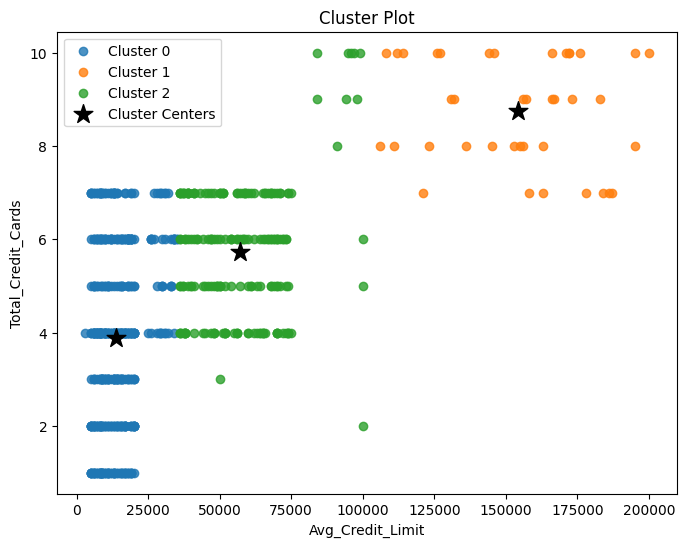

In [37]:
plt.figure(figsize=(8, 6))

for label in set(clusters_kmeans):
    cluster_data = x[clusters_kmeans == label]
    plt.scatter(cluster_data['Avg_Credit_Limit'], cluster_data['Total_Credit_Cards'], label=f"Cluster {label}", alpha=0.8)

plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='black', label='Cluster Centers', marker='*')

plt.title("Cluster Plot")
plt.xlabel("Avg_Credit_Limit")
plt.ylabel("Total_Credit_Cards")

plt.legend()
plt.show()

Disini kita akan simpulkan bahwa cluster 0 bisa dibilang member Platinum, Cluster 2 member Gold, dan Cluster 1 member Silver karena merekalah yang cenderung memiliki credit limit yang rendah dan jumlah credit card yang rendah juga.

Done!!! mari export modelnya untuk nanti digunakan pada streamlit yeay yeayy!!

#Export Model

In [38]:
with open("model.pkl", "wb") as f:
    pickle.dump(kmeans, f)

In [39]:
#DONE!!